In [120]:
import torch

from torchvision.transforms import ColorJitter, RandomAffine, RandomErasing
from helper import show_one

import matplotlib.pyplot as plt
import cv2
import numpy as np

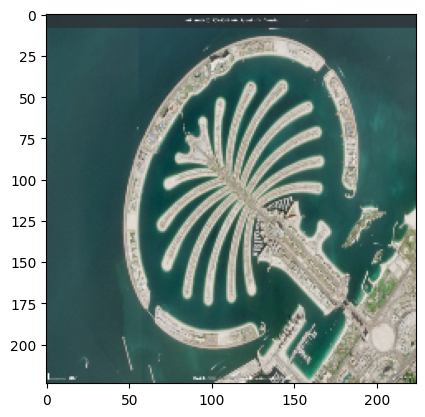

In [26]:
x = cv2.resize(plt.imread("Dubai.jpg"), (224, 224))
x = torch.tensor(x).permute(2,0,1).unsqueeze(0)

show_one(x)


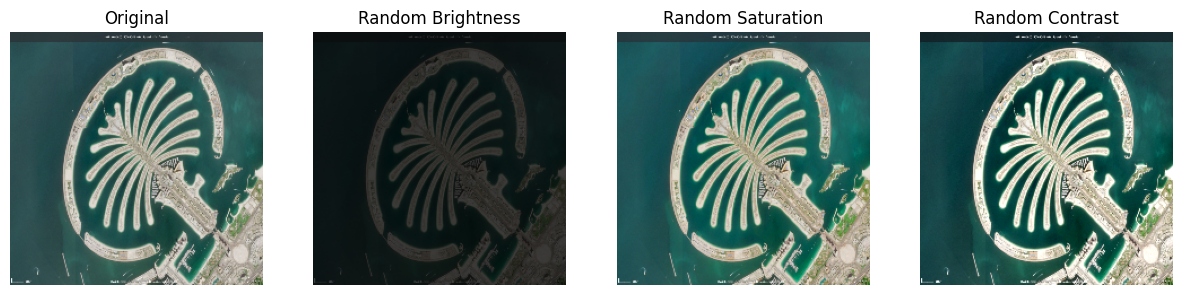

In [48]:
def rand_brightness(x: torch.Tensor, brightness: float = 1.) -> torch.Tensor:
    cj = ColorJitter(brightness=brightness)
    return torch.stack([cj(img) for img in x])

def rand_saturation(x: torch.Tensor, saturation: float = 1.) -> torch.Tensor:
    cj = ColorJitter(saturation=saturation)
    return torch.stack([cj(img) for img in x])

def rand_contrast(x: torch.Tensor, contrast: float = 1.) -> torch.Tensor:
    cj = ColorJitter(contrast=contrast)
    return torch.stack([cj(img) for img in x])

plt.figure(figsize=(15,15))

plt.subplot(1, 4, 1)
plt.title("Original")
show_one(x)
plt.axis("off")

plt.subplot(1, 4, 2)
plt.title("Random Brightness")
show_one(rand_brightness(x))
plt.axis("off")

plt.subplot(1, 4, 3)
plt.title("Random Saturation")
show_one(rand_saturation(x))
plt.axis("off")

plt.subplot(1, 4, 4)
plt.title("Random Contrast")
show_one(rand_contrast(x))
plt.axis("off")


plt.show()

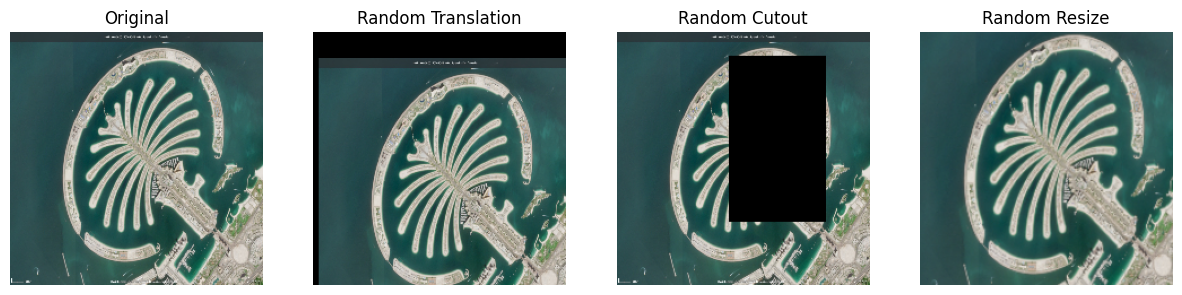

In [128]:
def rand_translation(x: torch.Tensor, ratio: float = 0.125) -> torch.Tensor:
    ra = RandomAffine(degrees=0, translate=(ratio, ratio))
    return torch.stack([ra(img) for img in x])

def rand_cutout(x: torch.Tensor, ratio: float = 0.25) -> torch.Tensor:
    re = RandomErasing(p = 1, scale = (ratio, ratio), value=0)
    return torch.stack([re(img) for img in x])

def rand_resize(x: torch.Tensor, min_ratio: float = 0.8, max_ratio: float = 1.2) -> torch.Tensor:
    resize_ratio = np.random.rand()*(max_ratio-min_ratio) + min_ratio
    resized_img = torch.nn.functional.interpolate(x, size=int(resize_ratio*x.shape[3]), mode='bilinear')
    org_size = x.shape[3]
    if int(resize_ratio*x.shape[3]) < x.shape[3]:
        left_pad = (x.shape[3]-int(resize_ratio*x.shape[3]))/2.
        left_pad = int(left_pad)
        right_pad = x.shape[3] - left_pad - resized_img.shape[3]
        x = torch.nn.functional.pad(resized_img, (left_pad, right_pad, left_pad, right_pad), "constant", 0.)
    else:
        left = (int(resize_ratio*x.shape[3])-x.shape[3])/2.
        left = int(left)
        x = resized_img[:, :, left:(left+x.shape[3]), left:(left+x.shape[3])]
    assert x.shape[2] == org_size
    assert x.shape[3] == org_size
    return x


plt.figure(figsize=(15,15))

plt.subplot(1, 4, 1)
plt.title("Original")
show_one(x)
plt.axis("off")

plt.subplot(1, 4, 2)
plt.title("Random Translation")
show_one(rand_translation(x))
plt.axis("off")

plt.subplot(1, 4, 3)
plt.title("Random Cutout")
show_one(rand_cutout(x))
plt.axis("off")

plt.subplot(1, 4, 4)
plt.title("Random Resize")
show_one(rand_resize(x))
plt.axis("off")

plt.show()

In [129]:
AUGMENT_FNS = {
    'color': [rand_brightness, rand_saturation, rand_contrast],
    'translation': [rand_translation],
    'resize': [rand_resize],
    'cutout': [rand_cutout],
}

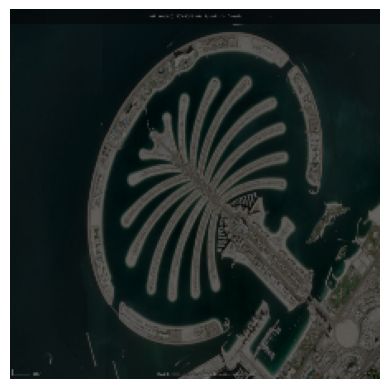

In [139]:
def DiffAugment(x: torch.Tensor, policy: str = '', channels_first: bool = True) -> torch.Tensor:
    if policy:
        if not channels_first:
            x = x.permute(0, 3, 1, 2)
        for p in policy.split(','):
            for f in AUGMENT_FNS[p]:
                x = f(x)
        if not channels_first:
            x = x.permute(0, 2, 3, 1)
        x = x.contiguous()
    return x

show_one(DiffAugment(x, 'color'))
plt.axis("off")
plt.show()